<p style="font-size:18pt"> Increase cells size </p>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

<p style="font-size:18pt"> Basic map code </p>

In [2]:
from ipyleaflet import Map
basic_map = Map(zoom = 1)
basic_map

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

<p style="font-size:18pt"> Basic .gpx file opening </p>

In [3]:
import gpxpy
#gpx_file_path = 'Gran_Fondo_Porto_SantElpidio_2022.gpx'
gpx_file_path = 'Cesena_Fontanella_Pantani_Sorrivoli_Centenara_Cesena.gpx'

with open(gpx_file_path) as fh:
    gpxFile = gpxpy.parse(fh)

<p style="font-size:18pt"> Import of packages </p>

In [4]:
from statistics import mean
#import ipyleaflet
from ipyleaflet import basemaps, FullScreenControl, LayerGroup, \
    MeasureControl, Polyline, Marker, CircleMarker, WidgetControl
from ipywidgets import Button, HTML, HBox, VBox, Checkbox, FileUpload, \
    Label, Output, IntSlider, Layout, Image, link
from bqplot import pyplot as plt
from bqplot import *

<p style="font-size:18pt"> .gpx file in a map </p>

In [5]:
#def plot_map(gpx):
"""
Plot the GPS trace on a map
"""
from ipyleaflet import Map

points = [p.point for p in gpxFile.get_points_data(distance_2d=True)]
mean_lat = mean(p.latitude for p in points)
mean_lng = mean(p.longitude for p in points)

# create the map
m = Map(center=(mean_lat, mean_lng), zoom=12, basemap=basemaps.Stamen.Terrain)

# show trace
line = Polyline(locations=[[[p.latitude, p.longitude] for p in points],],
                color = "red", fill=False)
m.add_layer(line)

# add markers
waypoints = [
    Marker(location=(point.latitude, point.longitude), title=point.name,
           popup=HTML(value=point.name), draggable=False)
    for point in gpxFile.waypoints
]
waypoints_layer = LayerGroup(layers=waypoints)
#m.add_layer(waypoints_layer)

# add a checkbox to show / hide waypoints
waypoints_checkbox = Checkbox(value=True, description='Show Waypoints')

def update_visible(change):
    for p in waypoints:
        p.visible = change['new']

waypoints_checkbox.observe(update_visible, 'value')
waypoint_control = WidgetControl(widget=waypoints_checkbox, position='bottomright')
m.add_control(waypoint_control)

# enable full screen mode
m.add_control(FullScreenControl())

# add measure control
measure = MeasureControl(
    position='bottomleft',
    active_color = 'orange',
    primary_length_unit = 'kilometers'
)
m.add_control(measure)

#return m
m

Map(center=[44.079069151812824, 12.218333058224683], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [6]:
# https://www.youtube.com/watch?v=jAKUPm-Cul0
#j = 90
#gpxFile.get_points_data(distance_2d=True)[j]#.tracks().segments[j]

<p style="font-size:18pt"> bqplot representation of altitude </p>

In [7]:
#def plot_elevation(gpx):
"""
Return an elevation graph for the given gpx trace
"""
points = gpxFile.get_points_data(distance_2d=True)
px = [p.distance_from_start / 1000 for p in points]
py = [p.point.elevation for p in points]

x_scale, y_scale = LinearScale(), LinearScale()
x_scale.allow_padding = False
x_ax = Axis(label='Distance (km)', scale=x_scale)
y_ax = Axis(label='Elevation (m)', scale=y_scale, orientation='vertical')

lines = Lines(x=px, y=py, scales={'x': x_scale, 'y': y_scale})

u = 90
elevation = Figure(title='Elevation Chart %d' %u, axes=[x_ax, y_ax], marks=[lines])


elevation.layout.width = 'auto'
elevation.layout.height = 'auto'
elevation.layout.min_height = '300px'

#elevation.interaction = IndexSelector(scale=x_scale)
#return elevation
elevation

Figure(axes=[Axis(label='Distance (km)', scale=LinearScale(allow_padding=False)), Axis(label='Elevation (m)', …

<p style="font-size:18pt"> from .gpx file to Pandas dataframe  </p>

In [8]:
import pandas as pd

j = 0
points = []
for segment in gpxFile.tracks[j].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
coords = pd.DataFrame.from_records(points)

<p style="font-size:18pt"> pandas datetime conversion into a integer of seconds  </p>

In [9]:
from datetime import datetime
timeList = [ datetime.timestamp( u ) for u in coords['time'] ]

<p style="font-size:18pt"> intervals of space, time and elevation. Speed calculation  </p>

In [10]:
DeltaTime = np.diff(timeList)
DeltaTime = np.append([0], DeltaTime)
coords['DeltaTime'] = pd.Series( DeltaTime )

#111.139e3 converts latitude/longitude into metres
DeltaLat = np.diff( coords['latitude'] )*111.139e3
DeltaLong = np.diff( coords['longitude'] )*111.139e3
DeltaElev = np.diff( coords['elevation'] )
DeltaSpace = ( DeltaLat**2 + DeltaLong**2 + DeltaElev**2 )**.5
steepness = DeltaElev/DeltaSpace

coords['steepness'] = pd.Series(steepness)
coords['DeltaSpace'] = pd.Series( DeltaSpace )
coords['DeltaSpace'].replace([np.inf, -np.inf], np.nan, inplace=True)

coords['speed'] = 3.6*coords['DeltaSpace']/coords['DeltaTime']
coords['speed'].replace([np.inf, -np.inf], np.nan, inplace=True)#removes singolarities
coords.head()

,time,latitude,longitude,elevation,DeltaTime,steepness,DeltaSpace,speed
0,2022-10-02 15:13:49+00:00,44.140379,12.238573,34.0,0.0,-0.019334,5.172216,NaN
1,2022-10-02 15:13:50+00:00,44.140386,12.238527,33.9,1.0,-0.011440,8.741073,31.467864
2,2022-10-02 15:13:52+00:00,44.140402,12.238450,33.8,2.0,-0.025171,3.972826,7.151087
3,2022-10-02 15:13:53+00:00,44.140413,12.238416,33.7,1.0,-0.015628,6.398759,23.035534
4,2022-10-02 15:13:55+00:00,44.140430,12.238361,33.6,2.0,-0.011584,8.632295,15.538132


<p style="font-size:14pt"> In case ALL values in a Series need to be showen  </p>

In [11]:
#Display ALL rows
pd.set_option('display.max_rows', None)
coords['speed']#[inLayers]

0              NaN
1        31.467864
2         7.151087
3        23.035534
4        15.538132
5        28.696539
6        31.577047
7        27.562851
8        26.110374
9        27.658514
10       27.270914
11       29.143709
12       23.693274
13       23.774212
14       19.976993
15       22.322625
16       22.917757
17       21.352021
18       22.222687
19       19.175623
20       17.717718
21       19.621243
22       22.291015
23       22.293922
24       15.695004
25       14.425825
26       18.812420
27       19.868520
28       18.202632
29       15.454444
30       19.770829
31       18.960747
32        7.386265
33       37.104299
34       10.653943
35       17.320235
36       29.194277
37       34.652021
38        6.652412
39       12.932651
40        3.960792
41       10.379502
42        6.685988
43        6.801707
44       15.396379
45        5.633465
46       14.094669
47       29.601508
48       12.716664
49       18.744222
50       19.108721
51       33.589944
52       12.

<p style="font-size:18pt"> Select outlayers  </p>

<p style="font-size:14pt"> out layers are supposed to be just values of speed which increase of more than 10 km/h in 1 sec. To be improved...  </p>

In [12]:
#in a bike gpx track, a difference of speeds of 10 km/h or more in between two gps points
#is highly unreasonable. Here points showing such a speed difference are discarted
diffSpeed = np.diff(coords['speed'])
maxSpeedDiff = 10
#speed difference excess indexes
inLayers = np.where( abs( diffSpeed ) < maxSpeedDiff )[0] 
outLayers = np.where( abs( diffSpeed ) > maxSpeedDiff )[0]

<IPython.core.display.Javascript object>


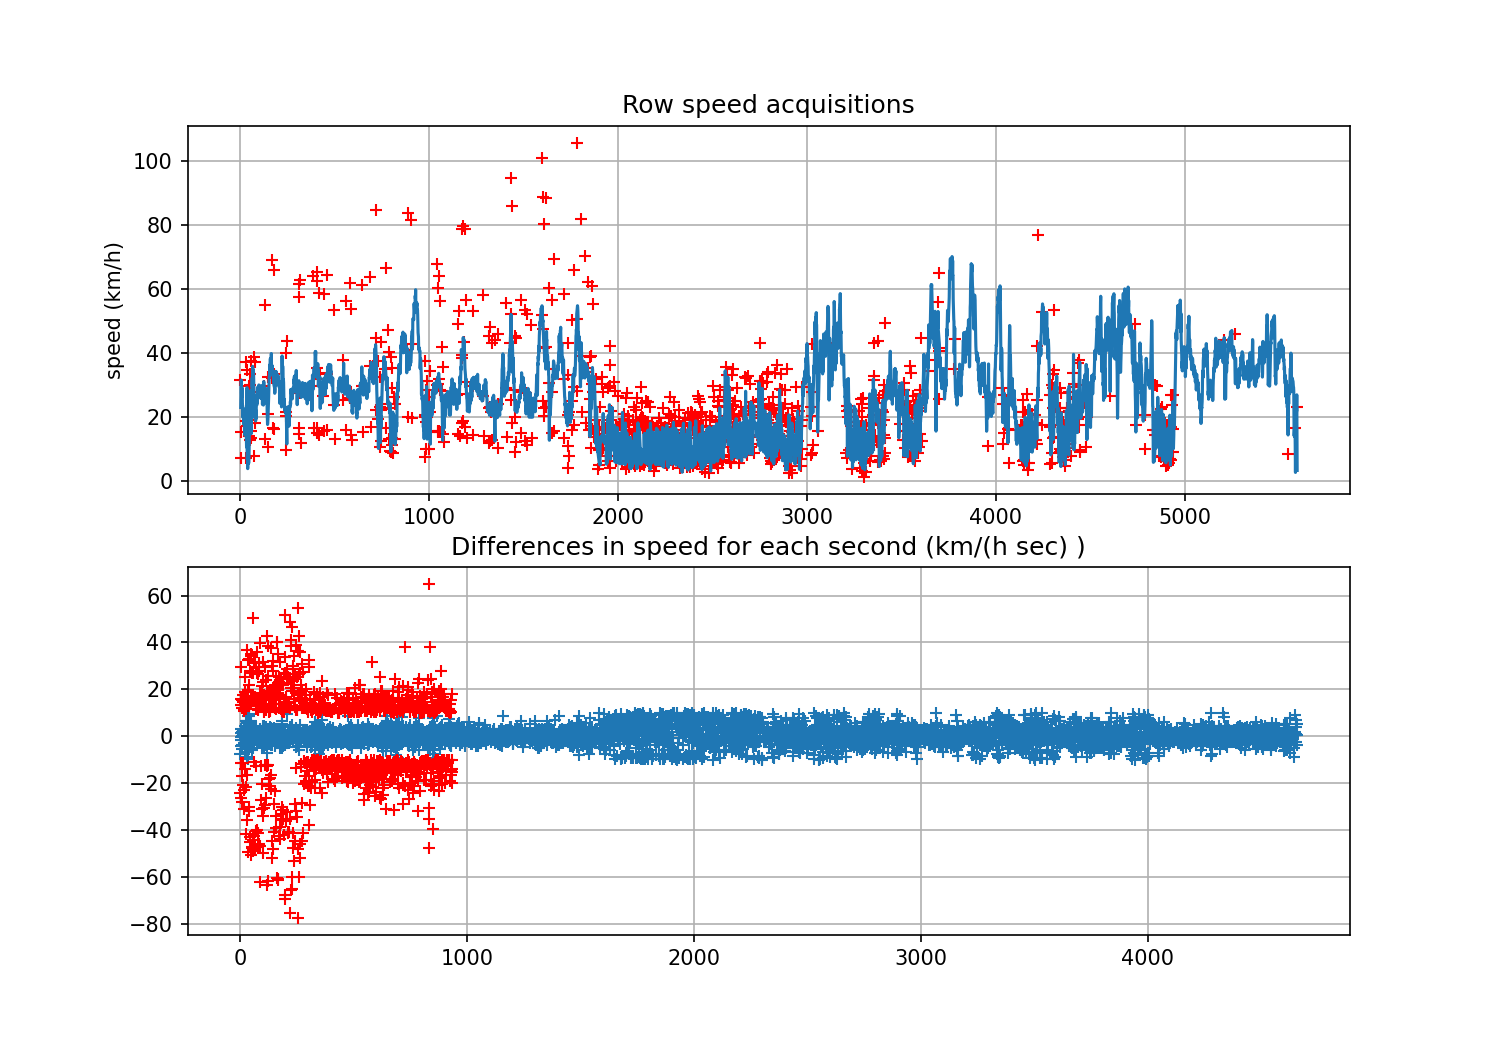

In [13]:
import matplotlib.pyplot as mp
%matplotlib notebook

mp.figure(figsize=(10,7))
mp.subplot(211)
mp.title('Row speed acquisitions')
mp.ylabel('speed (km/h)')
mp.plot(coords['speed'][outLayers], 'r+')
mp.plot(coords['speed'][inLayers])
mp.grid()

mp.subplot(212)
mp.title('Differences in speed for each second (km/(h sec) )')
mp.plot(diffSpeed[inLayers], '+')
mp.plot(diffSpeed[outLayers], 'r+')
mp.grid()
mp.show()

<p style="font-size:14pt"> Speeds of 100 km/h reported in the plots above are highly unreasonable for a bike tour. In order to discard wrong values, a plot of speed differences for each 1 sec are plotted. Measurements of speed which result in speed difference over 10 km/h in a second are showed in red and discarded from data   </p>

<p style="font-size:18pt"> Iterative average over N speeds  </p>

$$
N\bar{x}_0 = x_0 + x_1 + \dots x_{N-1} \\
N\bar{x}_1 = x_1 + x_2 + \dots x_{N} = N\bar{x}_0 - x_0 + x_N \\
N\bar{x}_2 = x_2 + x_3 + \dots x_{N+1} = N\bar{x}_1 - x_1 + x_{N+1} \\
\dots\\
N\bar{x}_j = x_j + x_{j+N-1} + \dots x_{N} = N\bar{x}_{j-1} - x_j + x_{N+j-1} \\
$$

In [14]:
N = 10 # number of speeds to be averaged

avSpeed = [] # iterative average speed
#idxs = []
firstSpeed = coords['speed'][inLayers].iloc[:10].sum()/N #average of first N speeds
avSpeed = avSpeed + [ firstSpeed ]

loopEnd = len(coords['speed'][inLayers]) - 10#.index[-1] to be checked
for j in range(loopEnd):
    xj = coords['speed'][inLayers].iloc[j]#x_j
    xjN = coords['speed'][inLayers].iloc[ N+j-1 ]#x_{N+j-1}
    avSpeed = avSpeed + [ avSpeed[j] + ( -xj + xjN )/N ]#\bar{x}_{j-1} - x_j + x_{N+j-1}
    #idxs = idxs + [ coords['speed'][inLayers].index[j] + int(N/2) ]

In [15]:
idxs = coords['speed'][inLayers].index[:-10] + int(N/2) #index of avSpeed centered
coords['avSpeed'] = pd.Series(avSpeed[:-1], index = idxs)#indexes size need to be equal to avSpeed size

<IPython.core.display.Javascript object>


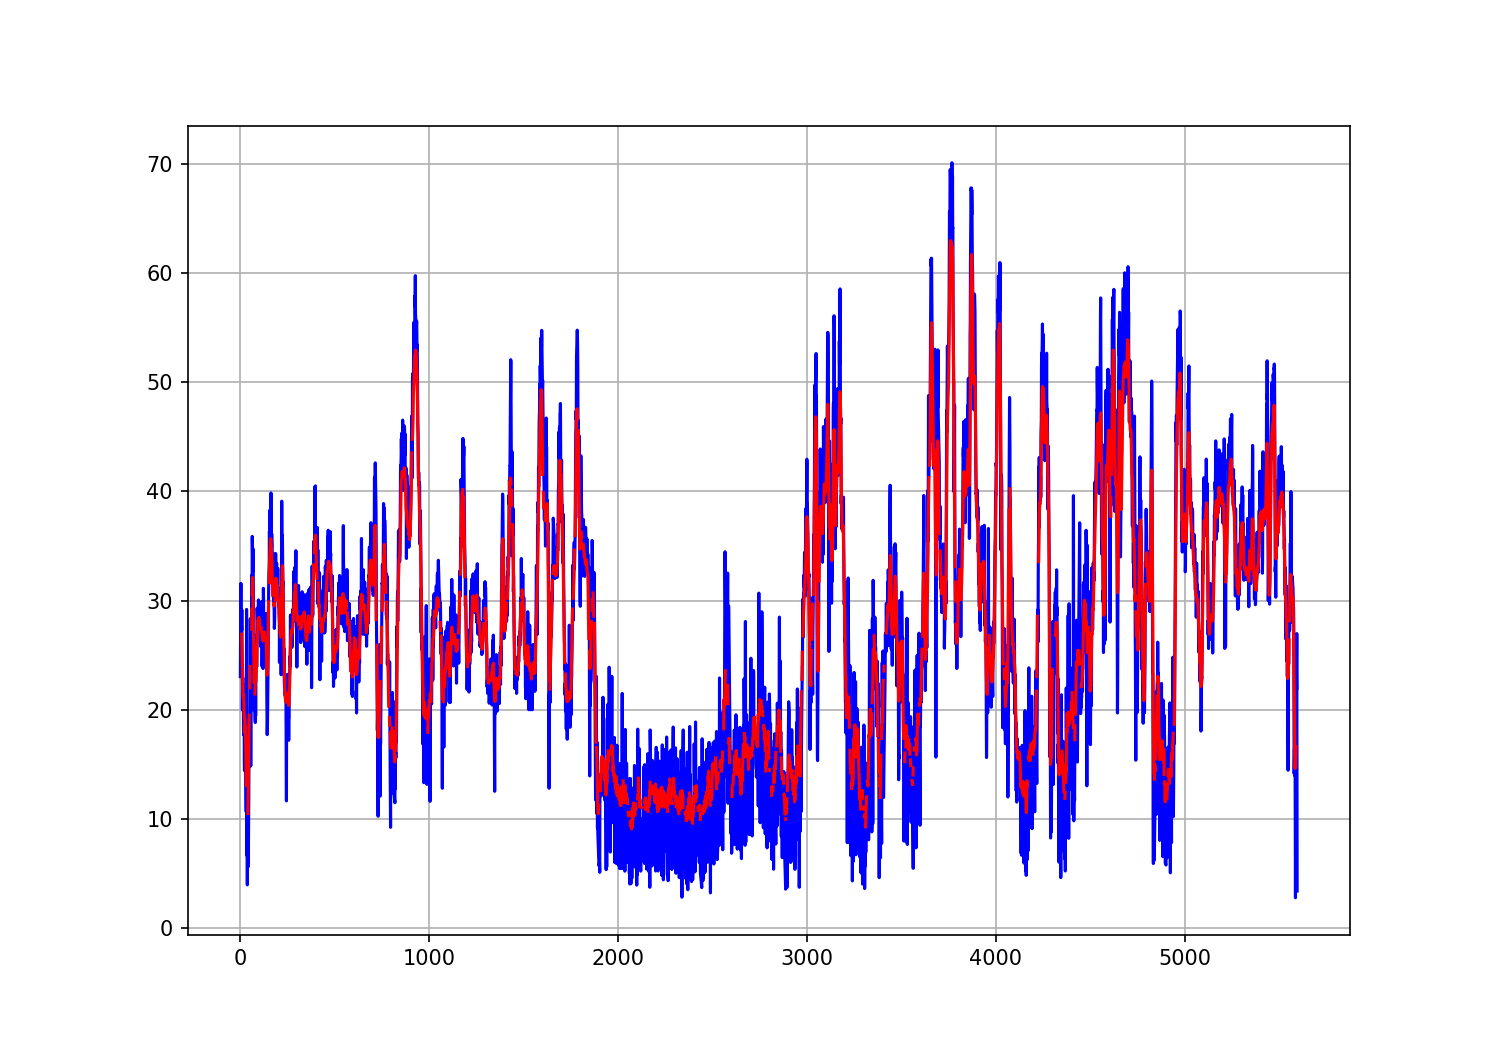

In [16]:
#Display ALL rows
#pd.set_option('display.max_rows', None)
#coords['speed'][inLayers]

mp.figure(figsize = (10,7) )
mp.plot(coords['speed'][inLayers], 'b')
mp.plot(coords['avSpeed'], 'r')
mp.grid()
mp.show()